In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
from tyssue import Sheet, SheetGeometry as geom
from tyssue import Monolayer, config
from tyssue.io import hdf5
from tyssue.draw import sheet_view
from tyssue.dynamics import model_factory, effectors

%matplotlib inline

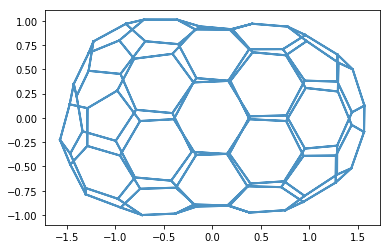

In [2]:
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet.hf5',
                           data_names=['vert', 'edge', 'face'])

sheet = Sheet('ellipse', dsets,
              config.geometry.cylindrical_sheet())

fig, ax = sheet_view(sheet, mode="quick", coords=list('zx'),
                     edge={"lw":2, "alpha":0.8})

In [3]:
sheet.settings['abc'] = 1., 1., 1.5

In [4]:
from tyssue import SheetGeometry

class EllipsoidGeometry(SheetGeometry):
    
    @staticmethod
    def update_rho(sheet):
        a, b, c = sheet.settings['abc']
        sheet.vert_df["rho2"] = (  
        (sheet.vert_df.x/a)**2
         + (sheet.vert_df.y/b)**2
         + (sheet.vert_df.z/c)**2)
    
    @classmethod
    def update_all(cls, sheet):
        super().update_all(sheet)
        cls.update_rho(sheet)


class EllipsoidConstraint(effectors.AbstractEffector):
    
    dimensions = None
    magnitude = 'ellipsoid_constraint'
    label = "Ellipsoidal shell sticking constraint"
    element = 'vert'
    specs = {"settings": {"abc": (1., 1., 1.)},
             "vert": {'ellipsoid_constraint': 1.}}
    
    def energy(sheet):
        return sheet.vert_df.eval('ellipsoid_constraint * (rho2 - 1)**2')
    
    def gradient(sheet):
        a, b, c = sheet.settings['abc']
        grad = pd.DataFrame(index=sheet.vert_df.index,
                            columns=['gx', 'gy', 'gz'])
        const = sheet.vert_df.eval(
                f'4*ellipsoid_constraint * (rho2 - 1)').values
        
        for coord, axis in zip(['x', 'y', 'z'], (a, b, c)):
            grad['g'+coord] = const * sheet.vert_df[coord].values / axis**2
    
        return grad, None
            


In [5]:
model = model_factory([
    effectors.LineTension,
    effectors.FaceAreaElasticity,
    EllipsoidConstraint], effectors.FaceAreaElasticity)



In [6]:
sheet.vert_df['ellipsoid_constraint'] = 1
sheet.face_df['prefered_area'] = sheet.face_df.area.mean()

EllipsoidGeometry.update_all(sheet)

In [7]:
model.compute_energy(sheet)

9.747734119192137

In [8]:
from tyssue.draw.plt_draw import plot_forces

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/tyssue-0.3rc1-py3.7-linux-x86_64.egg/tyssue/dynamics/factory.py:83: UserWarning: setting ucoords in grad computation,please fix your specs
  "setting ucoords in grad computation," "please fix your specs"


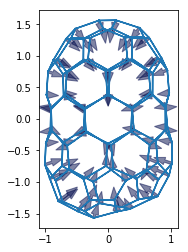

In [9]:
fig, ax = plot_forces(sheet, EllipsoidGeometry,
                      model, list('xz'), scaling=0.11)
ax.autoscale()

In [10]:
%pdb

Automatic pdb calling has been turned ON


In [11]:
from tyssue.solvers.quasistatic import QSSolver
import logging
logger = logging.getLogger('tyssue.topology.sheet_topology')
logger.setLevel('INFO')
import sys

handler = logging.StreamHandler(sys.stdout)
logger.addHandler(handler)

solver = QSSolver(with_collisions=True, with_t1=True, with_t3=True)


In [12]:

res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [13]:
logging.INFO

20

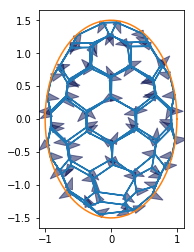

In [14]:
fig, ax = plot_forces(sheet, EllipsoidGeometry,
                      model, list('xz'), scaling=10)
ax.autoscale()
ts = np.linspace(0, 2*np.pi, 100)
a, b, c = sheet.settings['abc']
ax.plot(a*np.cos(ts), c*np.sin(ts))

In [15]:
fig, meshes = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [91]:
from tyssue.generation import ellipsoid_sheet
abc = 85, 85, 150
sheet = ellipsoid_sheet(*abc, 77, phase_err=1e-3, pos_err=1e-3)
print(sheet.Nf)

5946


In [17]:
sheet.vert_df['ellipsoid_constraint'] = 200.
sheet.face_df['prefered_area'] = sheet.face_df.area.mean()
sheet.face_df['area_elasticity'] = 1.

sheet.edge_df['line_tension'] = 0.07
EllipsoidGeometry.update_all(sheet)

In [18]:
sheet.settings['threshold_length'] = 1e-3


In [19]:
res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/tyssue-0.3rc1-py3.7-linux-x86_64.egg/tyssue/collisions/solvers.py:190: UserWarning: The collision was already present or its axis could not be determined
  """The collision was already present or its axis could not be determined"""


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [20]:
import ipyvolume as ipv

In [35]:
ipv.clear()
fig, meshes = sheet_view(sheet, mode='3D', face={'visible':True, 'color': sheet.face_df.area})
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [22]:
res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [27]:
sheet.edge_df.length.min()

0.06241927129657546

In [31]:
sheet.settings['threshold_length'] = 3e-1


In [34]:
res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

performing 2 T1
performing 2 T1
performing 8 T1
performing 4 T1
performing 12 T1
performing 4 T1
performing 4 T1
performing 4 T1
performing 4 T1
performing 4 T1
performing 4 T1
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [39]:
from tyssue.collisions import self_intersections
intersecting_edges = self_intersections(sheet)

In [40]:
intersecting_edges

array([], shape=(0, 2), dtype=int64)

In [37]:
from scipy.spatial import cKDTree



In [38]:
tree = cKDTree(sheet.face_df[sheet.coords].values)

In [43]:
sheet.edge_df.length.mean()

3.332612722670618

In [67]:
tree.data

array([[-6.03808040e+01, -1.72314892e+01,  1.00956779e+02],
       [-4.13765694e+01,  6.40259889e-02,  1.30905595e+02],
       [-4.39251673e+01,  7.55245003e-02,  1.28291998e+02],
       ...,
       [ 5.97886470e+01,  5.96137975e+01, -1.64381168e+01],
       [ 5.55288419e+01,  6.40027091e+01, -1.04184414e+01],
       [ 5.55004921e+01,  6.38022652e+01, -1.40632805e+01]])

In [61]:
pairs = np.array([[a, b] for a, b in tree.query_pairs(7)])

In [57]:
%pdb

Automatic pdb calling has been turned OFF


In [64]:
pairs = pd.DataFrame(pairs, columns=['A', 'B']).sort_values('A')

In [86]:
dist, indices = tree.query(tree.data, range(2, 8), distance_upper_bound=20, eps=1e-1)

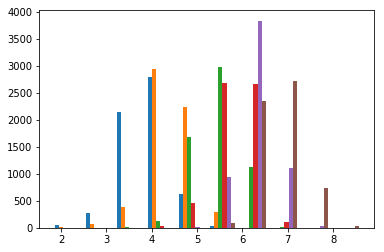

In [78]:
h = plt.hist(dist)

In [79]:
dist.shape

(5946, 6)

In [87]:
dist

array([[3.78593865, 4.23698193, 5.49474954, 5.54844279, 5.72826983,
        7.2442121 ],
       [3.65053054, 3.98707297, 5.77577856, 6.26688517, 6.38187773,
        6.76226011],
       [3.65053054, 4.04488332, 5.72960191, 6.4249375 , 6.69507237,
        6.80750181],
       ...,
       [3.69822452, 4.43488308, 6.22284621, 6.29726632, 6.37795262,
        6.44758724],
       [3.65045655, 4.25926058, 6.38790784, 6.39229571, 6.41676463,
        6.43892341],
       [3.65045655, 3.8909928 , 6.37014095, 6.39981484, 6.41285419,
        6.44758724]])

In [82]:
tree.data.shape

(5946, 3)

In [88]:
a = np.arange(10000)
b = np.random.random(10000)

%timeit (a + b).sum()
%timeit (a.sum() + b.sum())

38.1 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.1 µs ± 635 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [92]:
from tyssue.generation.shapes import get_ellipsoid_centers

In [93]:
abc


(85, 85, 150)

In [483]:
from dataclasses import dataclass
from scipy.optimize import check_grad


@dataclass
class ConstrainedPoints:
    '''Class for keeping track of an item in inventory.'''
    abc: tuple
    lagrange: float = 10.0
    eq_dist: float = None
    
    def update(self, points):
        
        a, b, c = self.abc
        self.points = points
        self.Np = points.shape[0]
        if self.eq_dist is None:
            self.eq_dist = 2 * c / np.sqrt(self.Np)

        self.rho2 = ((points / np.array([[a, b, c]]))**2).sum(axis=1) - 1
        self.tree = cKDTree(points)
        self.distances, self.indices = self.tree.query(
            self.tree.data, range(2, 8),
            eps=1e-1, n_jobs=-1)

    def energy(self):
        ellipsoid = (self.lagrange * self.rho2**2)
        springs =(0.5*(self.distances - self.eq_dist)**2).sum(axis=1)
        return (springs + ellipsoid).sum() / (6*self.Np)
    
    def gradient(self):
        grad_elastic = (
            (self.points[self.indices] - self.points[:, None, :])
            * (1 - self.eq_dist / self.distances[:, :, None])
        ).sum(axis=1)
        a, b, c = self.abc
        grad_ellipsis = 4*self.lagrange * self.rho2[:, None] * self.points /(np.array([[a, b, c]]))**2
        return -grad_elastic + grad_ellipsis
        
        
def cost_func(flat_pos, cp):
    cp.update(flat_pos.reshape((-1, 3)))
    return cp.energy()

def grad_func(flat_pos, cp):
    return cp.gradient().ravel()


In [380]:
from tyssue.generation import hexa_grid2d

In [383]:
points.shape

(100, 2)

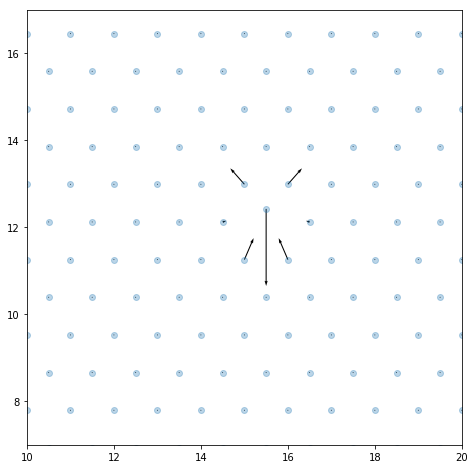

In [487]:
abc = (85, 85, 150)
points = get_ellipsoid_centers(*abc, 11, pos_err=1e-1)[['x', 'y', 'z']].values
points = np.zeros((900, 3))
points[:, :2] = hexa_grid2d(30, 30, 1, 1, noise=0)
points[:, 1] = points[:, 1]*np.sqrt(3)/2
points[435, 1] += 0.3



cp = ConstrainedPoints(abc, lagrange=0, eq_dist=1.)
cp.update(points)

fig, ax = plt.subplots()
ax.plot(points[:, 0], points[:, 1], 'o', alpha=0.3)
ax.quiver(*cp.points.T[:2], *-cp.gradient().T[:2], scale=5)
ax.set(ylim=(7, 17), xlim=(10, 20), aspect='equal')
fig.set_size_inches(8, 8)

In [488]:
res = minimize(cost_func, points.ravel(), args=(cp,), jac=grad_func)


In [485]:
check_grad(cost_func, grad_func, points.ravel(), cp, epsilon=1e-3) / cp.Np

0.013758171323091806

In [486]:
np.linalg.norm(cp.gradient(), axis=1).mean()


0.13963790075501414

In [427]:
res.fun

413.3586044187293

In [491]:
res

      fun: 0.008276364754939385
 hess_inv: array([[ 9.93791386e-01, -7.03810543e-03,  0.00000000e+00, ...,
         1.13018180e-02, -3.48079863e-04,  0.00000000e+00],
       [-7.03810543e-03,  9.83537613e-01,  0.00000000e+00, ...,
         2.55253409e-02, -8.33159891e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.13018180e-02,  2.55253409e-02,  0.00000000e+00, ...,
         9.68805335e-01,  8.13603566e-03,  0.00000000e+00],
       [-3.48079863e-04, -8.33159891e-03,  0.00000000e+00, ...,
         8.13603566e-03,  9.84580869e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
      jac: array([-0.5927003 , -0.99935121, -0.        , ...,  0.48261106,
        1.25057695, -0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 106
 

In [489]:
res['message']

'Desired error not necessarily achieved due to precision loss.'

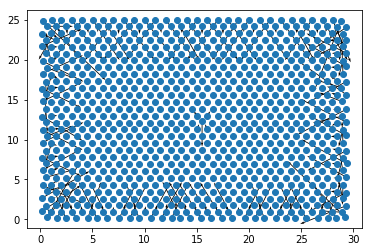

In [490]:
fig, ax = plt.subplots()
ax.plot(cp.points[:, 0], cp.points[:, 1], 'o')
ax.quiver(*cp.points.T[:2], *-cp.gradient().T[:2])

In [349]:
from tyssue import BulkGeometry, Epithelium
from tyssue.generation import from_3d_voronoi, single_cell
from scipy.spatial import Voronoi


def ellipsoid_sheet(a, b, c, n_zs, centers=None, **kwargs):
    """Creates an ellipsoidal apical mesh.

    Parameters
    ----------
    a, b, c : floats
       Size of the ellipsoid half axes in
       the x, y, and z directions, respectively
    n_zs : int
       The (approximate) number of faces along the z axis.

    kwargs are passed to `get_ellipsoid_centers`

    Returns
    -------
    eptm : a :class:`Epithelium` object

    The mesh returned is an `Epithelium` and not a simpler `Sheet`
    so that a unique cell data can hold information on the
    whole volume of the ellipsoid.

    """
    if centers is None:
        centers = get_ellipsoid_centers(a, b, c, n_zs, **kwargs)

    centers = centers.append(
        pd.Series({"x": 0, "y": 0, "z": 0, "theta": 0, "phi": 0}), ignore_index=True
    )

    centers["x"] /= a
    centers["y"] /= b
    centers["z"] /= c

    vor3d = Voronoi(centers[list("xyz")].values)
    vor3d.close()
    dsets = from_3d_voronoi(vor3d)
    veptm = Epithelium("v", dsets, config.geometry.bulk_spec())
    eptm = single_cell(veptm, centers.shape[0] - 1)

    eptm.vert_df["rho"] = np.linalg.norm(eptm.vert_df[eptm.coords], axis=1)
    eptm.vert_df["theta"] = np.arcsin(eptm.vert_df.eval("z/rho"))
    eptm.vert_df["phi"] = np.arctan2(eptm.vert_df["y"], eptm.vert_df["x"])

    eptm.vert_df["x"] = a * (
        np.cos(eptm.vert_df["theta"]) * np.cos(eptm.vert_df["phi"])
    )
    eptm.vert_df["y"] = b * (
        np.cos(eptm.vert_df["theta"]) * np.sin(eptm.vert_df["phi"])
    )
    eptm.vert_df["z"] = c * np.sin(eptm.vert_df["theta"])
    eptm.settings["abc"] = [a, b, c]
    BulkGeometry.update_all(eptm)
    return eptm


new = pd.DataFrame(res['x'].reshape((-1, 3)), columns=['x', 'y', 'z'])

sheet = ellipsoid_sheet(*abc, n_zs=5, centers=new)

ipv.clear()
fig, mesh = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [199]:
points.shape

(242, 3)